CAR - Cascade of Asymmetric Resonators
===

The code below implements a model of the cochlea developed by Dick Lyon.

This notebook is based on Chapter 16 of his [Human and Machine Hearing book](http://www.machinehearing.org). Page numbers in the code comments refer to the pages of the Author’s 2018 corrected manuscript of this book.

Notebook by André van Schaik, [International Centre for Neuromorphic Systems](https://www.westernsydney.edu.au/icns).

The cochlear model is a cascade of resonators, modelling the properties of the Basilar Membrane (BM), as shown below:

<p align="center"><img src="./images/CAR.png" alt="CAR" style="width: 600px;"/></p>

The resonators all look like this:

<p align="center"><img src="./images/filter.png" alt="filter" style="width: 300px;"/></p>

$X$ is the input of the section, coming from the sound source for the first section in the cascade, and from the output $Y$ of the previous section for each of the following sections.
$a_0$ and $c_0$ are are the coefficients of the filter, controlling the resonant frequency of each section. The resonant frequency will be highest for the first section and drop exponentially along the cochlea.
$r$ controls the radius of the poles and zeros and thus the damping.
$h$ controls the distance between the poles and the zeros in the frequency domain.
$g$ adjusts the dc gain. It uses a coupled-form realisation of a first order filter with a complex state variable and a single complex pole. The transfer function of such a filter is given by:

\begin{aligned}
&\frac{W}{X} = \frac{z}{z-(a+i c)} = U + iV\\
&\frac{U}{X} = \frac{1}{2}\;\left(\frac{W(z)}{X(z)}+\frac{W^*\left(z^*\right)}{X^*\left(z^*\right)}\right) = \frac{z(z-a)}{z^2-2 a z+\left(a^2+c^2\right)}\\
&\frac{V}{X} = \frac{1}{2 i}\left(\frac{W(z)}{X(z)}-\frac{W^*\left(z^*\right)}{X^*\left(z^*\right)}\right) = \frac{z c}{z^2-2 a z+\left(a^2+c^2\right)}
\end{aligned}

The filter shown above multiplies $V$ by $h$ and adds it to the input $X$. The sum is then multipled by $g$, which results in the following filter transfer function:
\begin{aligned}
\frac{Y}{X} & =g\left[1 + h \frac{z c}{z^2-2 a z+\left(a^2+c^2\right)}\right] \\
&= g\left[\frac{z^2+(-2 a+h c) z+\left(a^2+c^2\right)}{z^2-2 a z+\left(a^2+c^2\right)}\right] \\
&= g\left[\frac{z^2+\left(-2 a_0+h c_0\right) r z+r^2}{z^2-2 a_0 r z+r^2}\right]
\end{aligned}

with

\begin{aligned}
a &= a_0 r = \cos(\theta_r) r\\
c &= c_0 r = \sin(\theta_r) r\\
1 & = a_0^2 + c_0^2
\end{aligned}

The role of $g$ is to adjust the DC gain of the filter to unity. At DC, the one-time-step-delayed value of a signal (multiplication by $z$) is by definition the same as the signal itself (multiplication by $1$). Hence, the DC transfer function of the filter is simply:  
$$
H_{D C} = g\left[\frac{1+\left(-2 a_0+h c_0\right) r + r^2}{1 - 2 a_0 r + r^2}\right]
$$

Setting this to $1$ and solving for $g$, gives:
$$
g = \frac{1-2 a_0 r+r^2}{1-\left(2 a_0-h c_0\right) r+r^2}
$$

This is the value $g$ needs to have for each filter to ensure unity gain at DC.

Now, let's code this up.

In [1]:
%matplotlib widget
from pylab import *
from scipy import signal
w = 9.5                             # figure width in inches

First let's set the stimulation parameters:

In [2]:
fs = 48000.0                        # sample frequency
dur = 2                             # simulation duration
npoints = int(fs*dur)               # stimulus length

Next, we create a log-sine-sweep using the *chirp* function from the *scipi.signal* library:

In [3]:
# create a log-sine-sweep
f0 = 20                             # sweep start frequency
f1 = 20000                          # sweep end frequency
t1 = arange(npoints)/fs             # sample times
stimulus = 0.9 * signal.chirp(t1, f0, t1[-1], f1, method='logarithmic', phi=-90)
# stimulus[0:int(fs/100)] *= np.sin(linspace(0, pi/2, int(fs/100)))**2 # you can use this to add a 10ms cosine ramp up.
# stimulus[-int(fs/100)-1:-1] *= np.cos(linspace(0, pi/2, int(fs/100)))**2 # and ramp down.


And this is what it looks like:

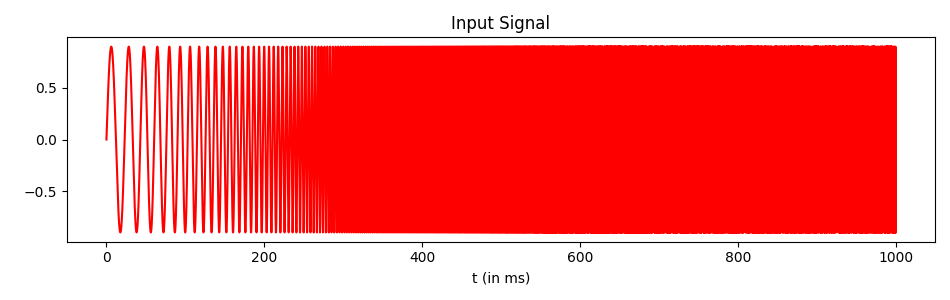

In [4]:
if fignum_exists(0): close(0)
figure(0, figsize=(w, 3))           # Sweep
plot(t1 * 500, stimulus, 'r')
xlabel('t (in ms)')
title('Input Signal');
tight_layout()

Now we define the number of cochlear filters and the range of Basilar Membrane positions to spread these filters over with equal spacing.

In [5]:
nsec  = 100                         # number of sections in the cochlea between
xlow  = 0.1                         # lowest frequency position along the cochlea and
xhigh = 0.9                         # highest frequency position along the cochlea

Once all these parameters are defined, we can calculate the parameters for the CAR model. The frequencies of the resonators are spaced according to the Greenwood formula, while the damping controls the poles. The choice of $h = c_0$ sets the zeros for each section about half an octave above the location of the poles. $g$ is calculated to provide 0dB gain at DC.

In [6]:
x = linspace(xhigh, xlow, nsec)     # position along the cochlea 1 = base, 0 = apex
f = 165.4 * (10**(2.1 * x) - 1)     # Greenwood frequency mapping for humans
a0 = cos(2 * pi * f / fs)           # a0 and c0 control the poles and zeros
c0 = sin(2 * pi * f / fs)

damping = 0.2                       # damping factor
r = 1 - damping * 2 * pi * f / fs   # pole & zero radius
h = c0                              # p285 h = c0 puts the zeros 1/2 octave above poles
g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)  
                                    # p285 this gives 0dB DC gain for BM

Before we run the simulation, we initialise the variables as needed ...

In [7]:
W = zeros(nsec)                     # BM filter internal state W (real part)
V = zeros(nsec)                     # BM filter internal state V (imaginary part)
BM = zeros((nsec, npoints))         # BM displacement
BM[-1] = stimulus                   # put stimulus at BM[-1] to provide input to BM[0]

and then we simulate the whole system for each sample time and for all cochlear sections.

In [8]:
for t in range(npoints):
    for s in range(nsec):
        Wnew = BM[s-1, t] + r[s] * (a0[s] * W[s] - c0[s] * V[s])
        V[s] = r[s] * (a0[s] * V[s] + c0[s] * W[s])
        W[s] = Wnew
        BM[s, t] = g[s] * (BM[s-1, t] + h[s] * V[s])
        

After playing the sweep signal through the cochlea, i.e., using it as the stimulus and simulating all time steps, we can get the frequency response and phase response of each cochlear filter by calculating:

In [9]:
# play the stimulus through the system and measure the output
output = BM

# use the FFT of the stimulus and output directly to calculate the transfer function
myFFT = fft(zeros((nsec, npoints)))
for s in range(nsec):
    myFFT[s] = (fft(output[s]) / fft(stimulus))
    

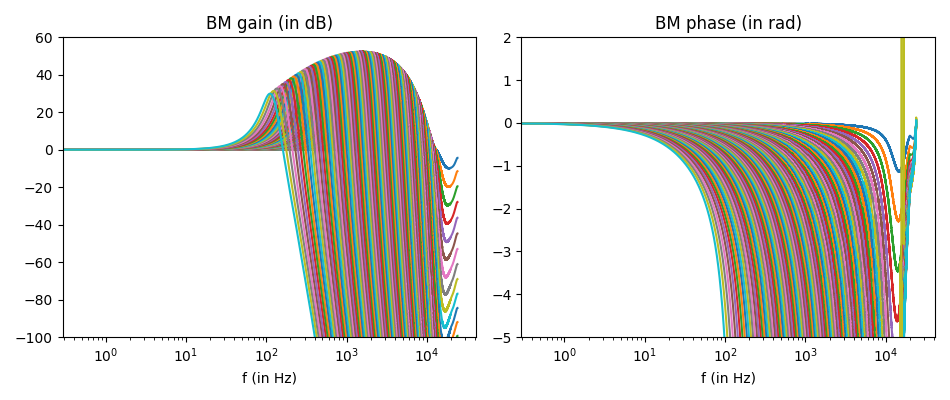

In [10]:
if fignum_exists(1): close(1)
fig = figure(1, figsize=(w, 4))     # Bode plot of BM displacement 
ax1 = subplot(1, 2, 1)
freq = linspace(0, fs // 2, (npoints) // 2)
semilogx(freq, 20 * log10(abs(myFFT.T[0 : npoints // 2, :]) + 1e-10))  
# note, 1e-10 offset above to avoid division by zero in log10
title('BM gain (in dB)')
ylim([-100, 60])
xlabel('f (in Hz)')
ax2 = subplot(1, 2, 2, sharex = ax1)
semilogx(freq, unwrap(angle(myFFT.T[0 : npoints // 2, :]), discont = 5, axis = 0))
title('BM phase (in rad)')
ylim([-5, 2])
xlabel('f (in Hz)')
tight_layout()

From this, we can also determine the impulse response of each filter.

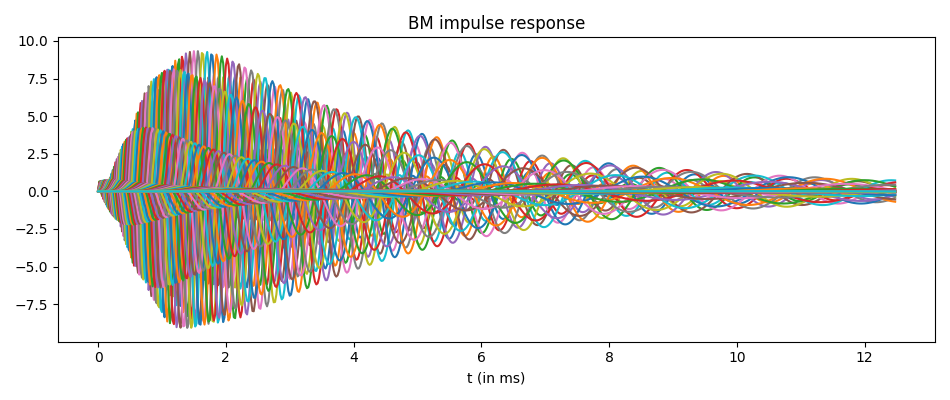

In [11]:
# calculate the BM impulse response
IR = real(ifft(myFFT))
IR[:, 0] = zeros(nsec)              # remove artefact

if fignum_exists(2): close(2)
figure(2, figsize=(w, 4))           # BM impulse response
L=600
plot(arange(L) * 1000 / fs, IR[:, 0 : L].T)
xlabel('t (in ms)')
title('BM impulse response')
tight_layout()

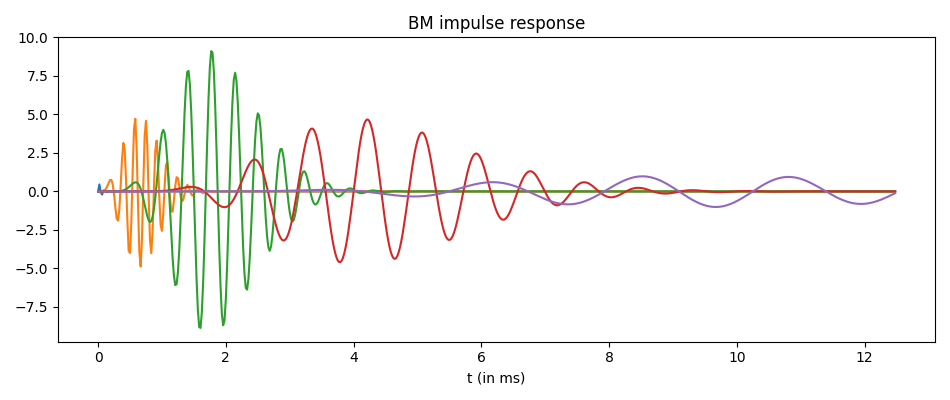

In [12]:
# plot only a few of the BM impulse responses

if fignum_exists(3): close(3)
figure(3, figsize=(w, 4))           # BM impulse response
L=600
plot(arange(L) * 1000 / fs, IR[10::20, 0 : L].T)
xlabel('t (in ms)')
title('BM impulse response')
tight_layout()

In [13]:
# If true then scrolling while the mouse is over the canvas will not move the entire notebook
fig = gcf()
fig.canvas.capture_scroll = True

Next, we add the [Fast Acting Compression](./CARFAC.ipynb).